# CVAE Notebook

### Implements the training, testing and evaluation scripts for the CVAE architecture in a segemented organised manner.

## 1. Importing Relevant Modules


In [1]:
import numpy as np
from scipy.optimize import dual_annealing
import torch
import torch.optim 
from torch.utils.data import DataLoader, TensorDataset
import glob

import os
from tqdm import tqdm
import random
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import json
from matplotlib.ticker import AutoMinorLocator

import data_utils as du
import cvae_tools as nt
import model_eval as me

import importlib

importlib.reload(me)
importlib.reload(nt)
importlib.reload(du)

DEVICE = torch.device("mps")

s = 42

torch.use_deterministic_algorithms(True)
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

np.random.seed(s)
torch.manual_seed(s)
torch.mps.manual_seed(s)
random.seed(s)

os.chdir('/Users/Mak/Desktop/Imperial College London/Year Four/MSci Project/Codebase/')

## 2. Setting Variables

* `normal_path`: The Directory to stores min-max normalised data and model outputs.

* `raw_path`: The directory storing csvs and json files from the MC Simulation Software.

    * CSV: Event-wise observables data - in the order: q2, cos_theta_l, cos_theta_d, phi

    * JSON: The input wilson coefficients for the simulation software.

* `number_bins`: The number of bins in each dimension of the simulation data

* `train_amt`: How many of the MC dataset to used to train the model. This is usually ~70-80% of the dataset.

In [8]:
normal_path = 'nn_outputs/wilson_tau_csr_cvr_KLD_0.1'
raw_path = 'raw_data/dstore_tau_csr_cvr'

number_bins = 10

## 3. Normalising Variables

* Use set variables min-max normalise observables and construct 4d histograms. Then min-max normalise the bin-heights as well.

* Only needs to be run once per dataset.

In [4]:
du.file_to_normalise_4d(raw_path, normal_path, number_bins, bkg=False) 

Processing File No. model_WET_mu_1411: 100%|██████████| 3570/3570 [10:25<00:00,  5.70it/s]


## 4. Load in Data:

1. Min-max normalise the bin-heights of the whole dataset

2. Load in min-max normalised data, store them in appropriate variables and create dataloaders for model pass through.


In [9]:
number_of_files = len(glob.glob(normal_path + '/normal_targets/*.csv'))

train_amount = int(0.7 * number_of_files)
val_amount = int(0.15 * number_of_files)

In [10]:
train_inputs, train_targets, val_test_inputs, val_test_targets, file_names = du.load_minmax_heights(normal_path, train_amount)

# =-=-=-= Splitting the remaining data into validation and testing datasets =-=-=-=
val_inputs, val_targets = val_test_inputs[:val_amount], val_test_targets[:val_amount]

test_inputs, test_targets = val_test_inputs[val_amount:], val_test_targets[val_amount:]

# =-=-=-= Load in the Bayesian Optimised Hyperparmaeters into a Dictionary =-=-=-=
cfg = nt.BO_CVAE(normal_path, train_inputs, train_targets)

CSV Files: Bin Heights Already Normalised.


## 4(a). Create Data-Loaders with the above data, Ready for Model Passthrough

In [7]:
# =-=-= DataLoader Initialisation =-=-=
load_train = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=cfg['batch_train'], shuffle=True, num_workers=0)

load_val = DataLoader(TensorDataset(val_inputs, val_targets), batch_size=cfg['batch_test'], shuffle=False, num_workers=0)

load_test = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=cfg['batch_test'], shuffle=False, num_workers=0)

# =-=-= DataLoader Used for Model Output Storage Only =-=-=
load_vis = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=1, shuffle=False, num_workers=0)

## 5. Training the Model:

1. Initialise loss function, Optimised-Model, and Optimiser.

2. Initialise variables to store loss evolution and Early Stopping parameters.
    - Loss evolution plotted later as a sanity check.

    - Early Stopping: adjust only `early_stopping_patience` (integer) to adjust how strict training should be.

3. Run the training loop - `train_epoch_early_CVAE` in the `CVAE_tools.py` notebook takes in:
    - Model, Training dataloader, Validation dataloader, Loss Function, Optimiser, and operating DEVICE (GPU or CPU)

    - This function takes care of all the loss calculation, backpropagation and optimiser steps.

    - Returns Losses, which are stored and compared for early stopping.

4. Store the Trained Model - Adjust the filename however you want - Variable: `save_path`

In [6]:
def loss_function_KLD(reconstruction, x, mean, logvar, beta=0.1, target_std=1.0):
    MSE = torch.nn.functional.mse_loss(reconstruction, x, reduction='mean')

    target_logvar = torch.log(torch.tensor(target_std ** 2).to(DEVICE))
    
    KLD = -0.5 * torch.mean(1 + (logvar - target_logvar) 
                                - (logvar.exp() / target_std ** 2))
    
    loss = MSE + beta * KLD
    return loss, MSE, KLD

def loss_normal(reconstruction, x, mean, logvar, beta=0.1):
    
    MSE = torch.nn.functional.mse_loss(reconstruction, x, reduction='mean')

    KLD = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    loss = MSE + beta * KLD
    return loss, MSE, KLD


In [7]:
# =-=-=-= 1. Define the Loss Function and Model using Bayesian Optimised Hyperparameters =-=-=-=
loss_func = loss_function_KLD
base = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'],
                    encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                   dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])
base.to(DEVICE)

# =-=-=-= 1. Optimiser specified =-=-=-=
optimiser = torch.optim.AdamW(base.parameters(), lr=1e-3, weight_decay=1e-4)

# 2. Variables to store losses plotted out later
loss_evol = []
val_loss_evol = []
mse_evol = []
kld_evol = []

# 2. Early Stopping Conditions - adjust only the patience value based on How constrained you want it.
early_stopping_patience = 10
best_val_loss = np.inf
epochs_without_improvement = 0

# 3. Training loops

for epoch in (pbar := tqdm(range(cfg['epochs'] + 50))):
    avg_loss, avg_val_loss, avg_mse, avg_kld = nt.train_epoch_early_CVAE(base, load_train, load_val, loss_func, optimiser, DEVICE)
    pbar.set_description(f"Training Epoch: {epoch + 1}/{cfg['epochs']}, Avg. Training Loss: {avg_loss:.5f}, Avg. Validation Loss: {avg_val_loss:.5f}")

    loss_evol.append(avg_loss)
    val_loss_evol.append(avg_val_loss)

    mse_evol.append(avg_mse)
    kld_evol.append(avg_kld)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0

    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# =-=-=-= 4. Change normal path where appropriate =-=-=-=-=
save_path = normal_path + '/CVAE_mu_4d.pth'
torch.save(base.state_dict(), save_path)

# plt.plot(list(range(cfg['epochs'])), loss_evol)

Training Epoch: 113/150, Avg. Training Loss: 0.00118, Avg. Validation Loss: 0.00119:  56%|█████▌    | 112/200 [02:14<01:45,  1.20s/it]

Early stopping triggered after 113 epochs.


## 5(a). Training-Validation Loss Evolution Plot

In [ ]:
idx = 0

import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 15
ax.plot(list(range(cfg['epochs']))[idx:len(loss_evol)], np.array(loss_evol)[idx:], 'o-', markersize=3,  color='blue', label='Training Loss')
ax.plot(np.array(list(range(cfg['epochs'])))[idx:len(loss_evol)], np.array(val_loss_evol)[idx:] , 'o-', markersize=3, color='red', label='Validation Loss')

ax.set_xlabel('Epochs', fontsize=20,)
ax.set_ylabel('Loss', fontsize=20,)
ax.set_title('Model Loss Convergence in Training \n Tau Decay; Wilson Coefficients cSR and cVR', fontsize=20)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Forces scientific notation with x10^4
ax.yaxis.set_major_formatter(formatter)

ax.tick_params(
            axis='both',
            which='major',
            direction='in',
            length=12,
            right=True,
            top=True,
            width=1.5,
        )

ax.tick_params(
            axis='both',
            which='minor',
            direction='in',
            length=6,
            right=True,
            top=True,
            width=1.5,
        )

handles, labels = ax.get_legend_handles_labels()

fig.legend(
        handles=handles,  # Ensure you pass the correct handles for the legend
        labels=labels,    # Ensure you pass the correct labels for the legend
        loc='lower center',
        ncol=4,
        bbox_to_anchor=(0.5, -0.03),  # Centered at the bottom
        fontsize=20
    )


## 6. Testing the Model

1. Initialising loss function, retrieving the trained model and loading it in.

2. Run the testing function - evaluates the whole testing set and returns losses
    - Good performance here should give values similar to the training loss

3. Goes 1 by 1 - Using visualisation dataset to extract model outputs for each dataset 
    - Visualise Each dataset compared to EOS and directly verify performance..

In [8]:
# =-=-= 1. Initialising of Testing Variables =-=-=
best_model = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], 
                         encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                         dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

# =-=-= 1. Load best model data =-=-=
best_model.load_state_dict(torch.load(save_path, weights_only = False))
best_model.to(DEVICE)

# =-=-= 2. Run the testing epoch - Operates like the training epoch without gradient calculation =-=-=
out = nt.test_epoch_CVAE(best_model, load_test, loss_function_KLD, DEVICE)
print('Average Loss of Test Set', out)

# =-=-= 3. Store the model's outputs for the testing dataset =-=-=
store_test = nt.test_visualise_4d_CVAE(best_model, load_vis, DEVICE, train_amount + val_amount, normal_path, number_bins, file_names)

Average Loss of Test Set 0.0012069953720210426


536it [00:22, 24.35it/s]


## 6(a). Plot out Integrated Histogram of One Variable

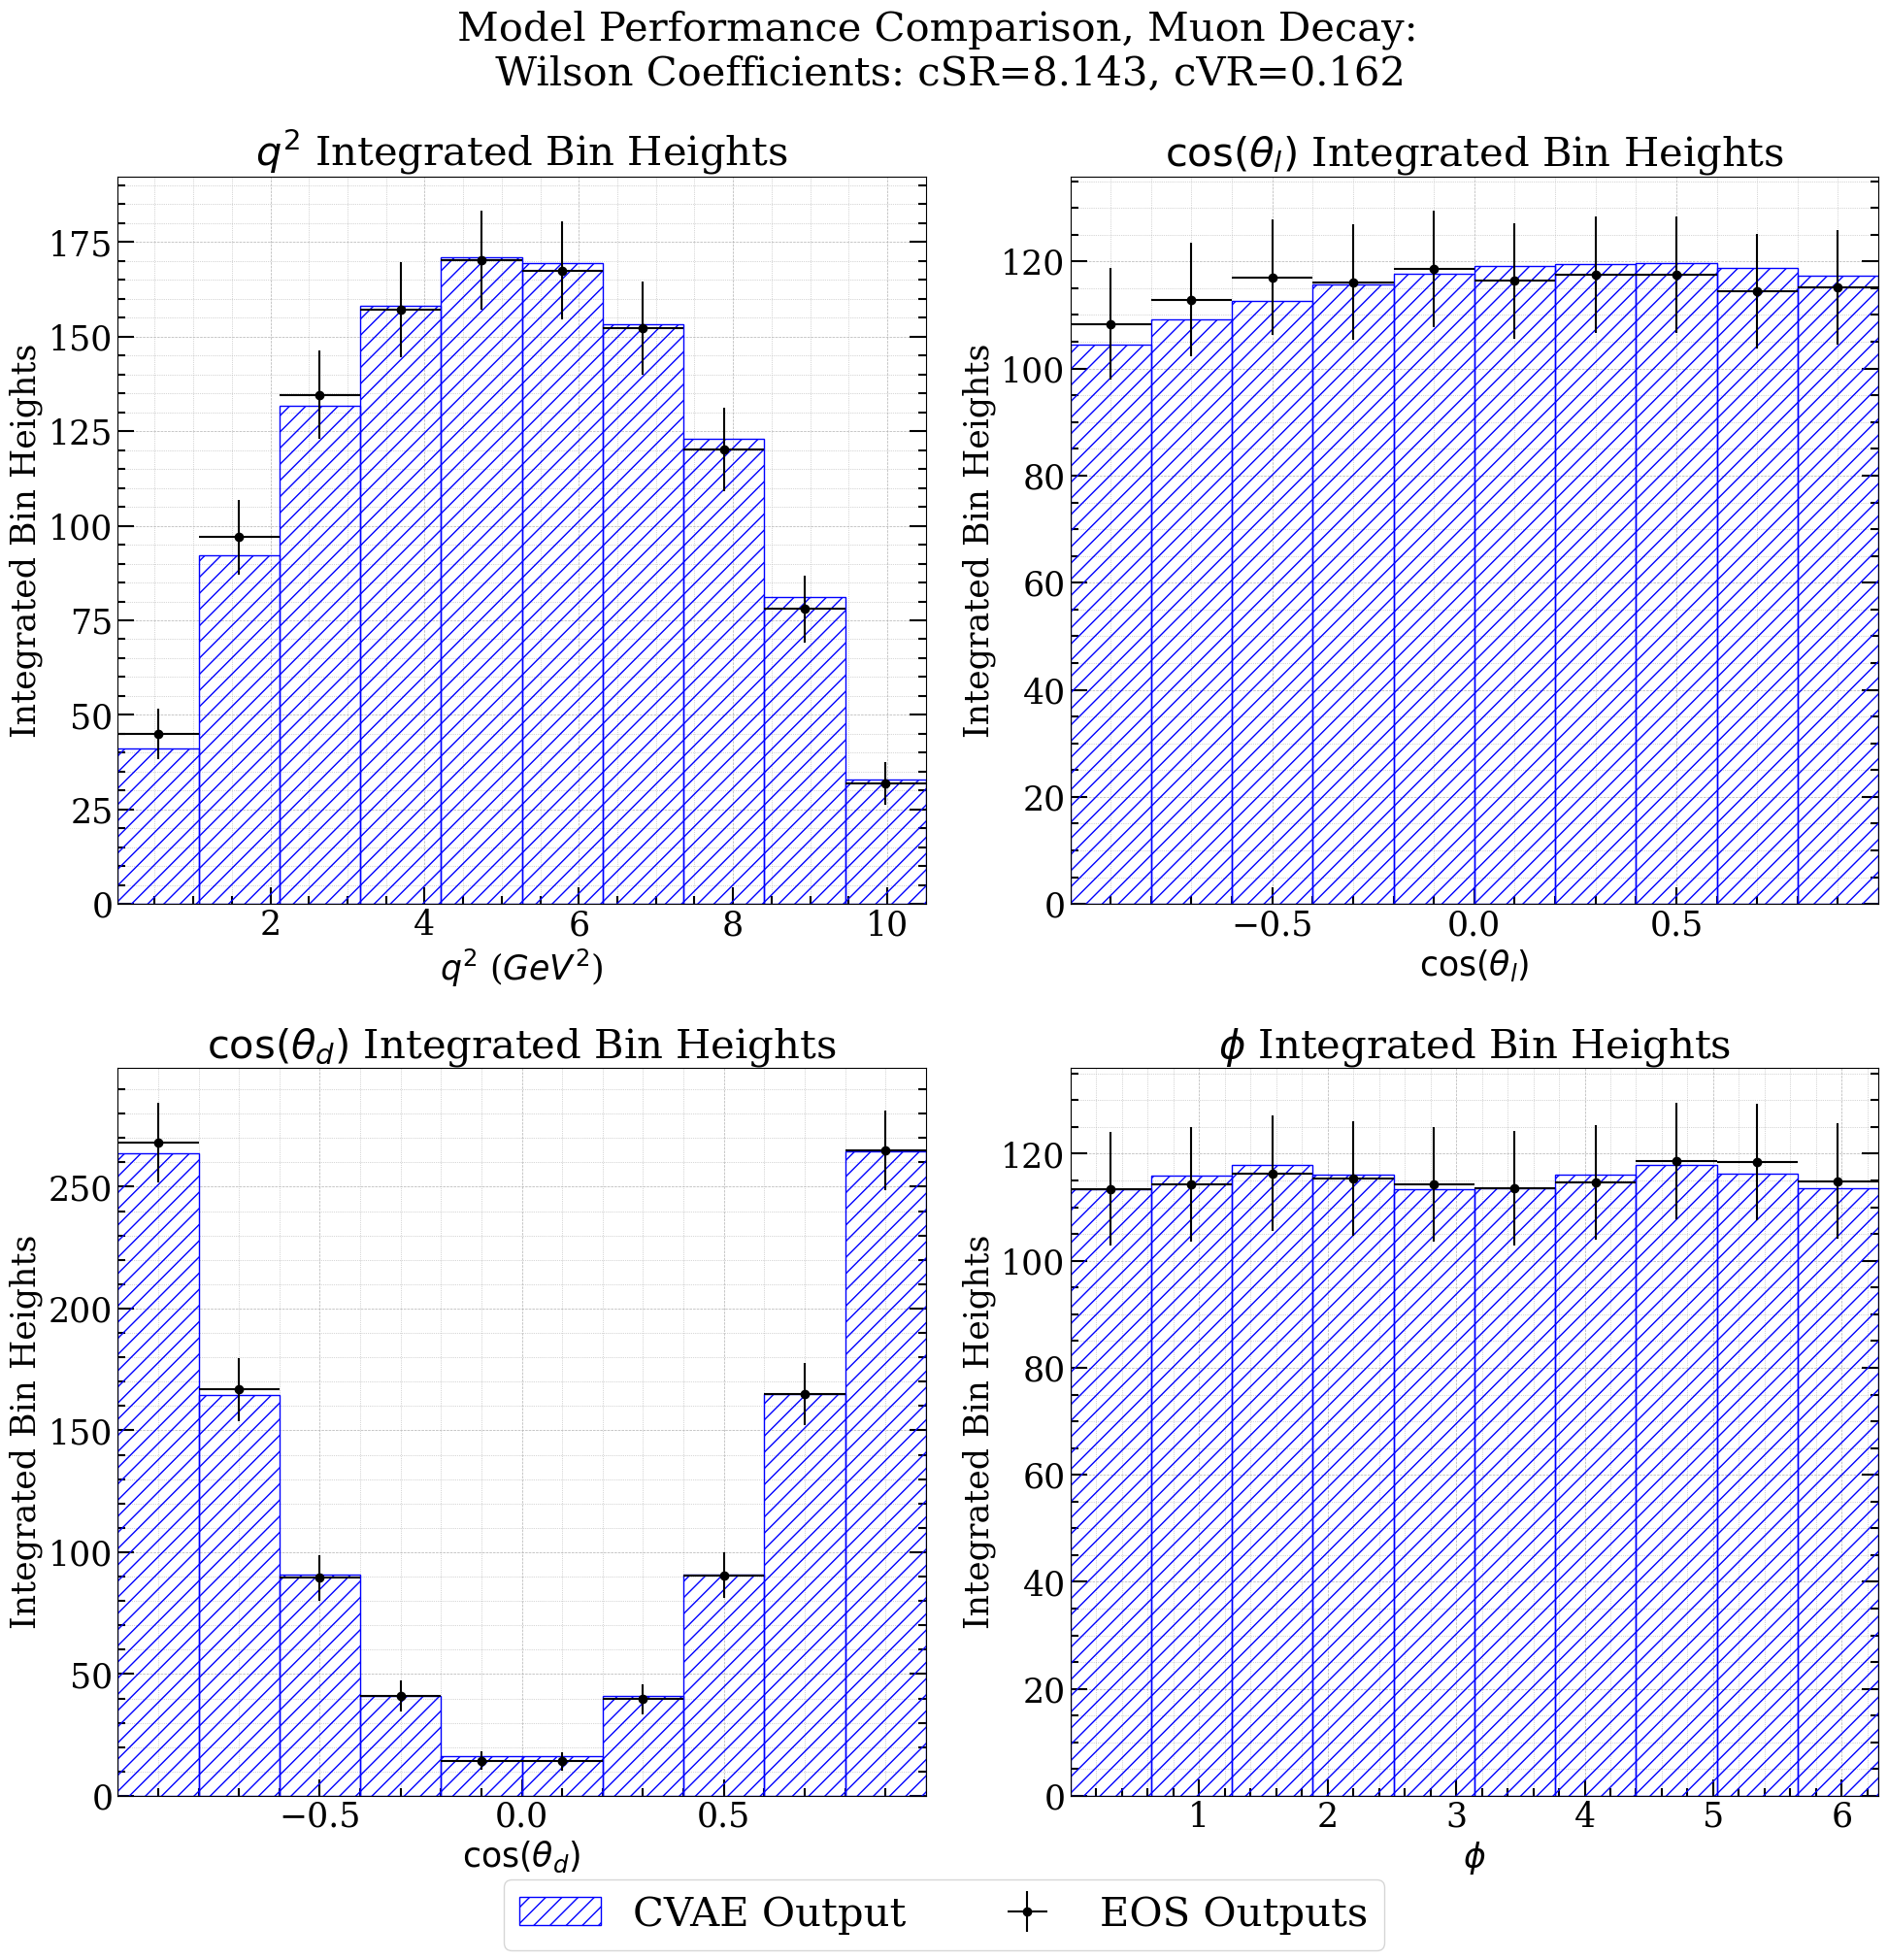

In [3]:
# File number must exist in the model_outputs directory
importlib.reload(me)

# 1088 and 960 are good contrast plots
# 3214 and 2052 are good for m
me.plot_1d_all_mu(data_path="nn_outputs/wilson_mu_csr_cvr", filenumber=3214)

## 7. CVAE Regression

* Initialise Model Passthrough, and Loss Functions.

In [24]:
def model_outputs_CVAE(wilson, model_CVAE):
    w1, w2 = wilson
    input = torch.Tensor(np.array([[w1, w2]])).to(DEVICE)

    # =-=-= CVAE Method of Reading Outputs =-=-=
    outputs = model_CVAE.generate_histogram(input)
    outputs = outputs.to('cpu')
    
    return outputs.detach().numpy()

class Objective_Function():
    def __init__(self, obj_heights, model):
        self.heights = obj_heights
        self.model = model

    def MSE_CVAE(self, wilson):
        predicted_outputs = model_outputs_CVAE(wilson, model_CVAE=self.model)
        MSE = np.mean((predicted_outputs - self.heights)**2)
        return MSE

def actual_wilson(json_config):
    with open(json_config, 'r') as f:
        return json.load(f)
    
nn_state_path = 'nn_outputs/wilson_tau_csr_cvr_KLD_0.1/CVAE_tau_4d.pth'
data_path = 'nn_outputs/wilson_tau_csr_cvr_KLD_0.1/normal_targets/model_WET_tau_10.csv'
config_path = 'nn_outputs/wilson_tau_csr_cvr_KLD_0.1/normal_inputs/model_WET_tau_10.json'

In [25]:
eos_df = pd.read_csv(data_path, index_col=0)
eos_bin_heights = eos_df['bin_height'].values

wcs = actual_wilson(config_path)

model_ideal = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], 
                         encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                         dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

model_ideal.load_state_dict(torch.load(nn_state_path, map_location=DEVICE, weights_only=False))
model_ideal.to(DEVICE)
model_ideal.eval()

bounds = [(0,1),(0,1)]

obj = Objective_Function(obj_heights=eos_bin_heights, model=model_ideal)

multi = []

for i in tqdm(range(75)):
    result = dual_annealing(obj.MSE_CVAE, bounds, maxfun=1e3).x
    multi.append(result)

actual_wc = actual_wilson(config_path)

100%|██████████| 75/75 [02:54<00:00,  2.33s/it]


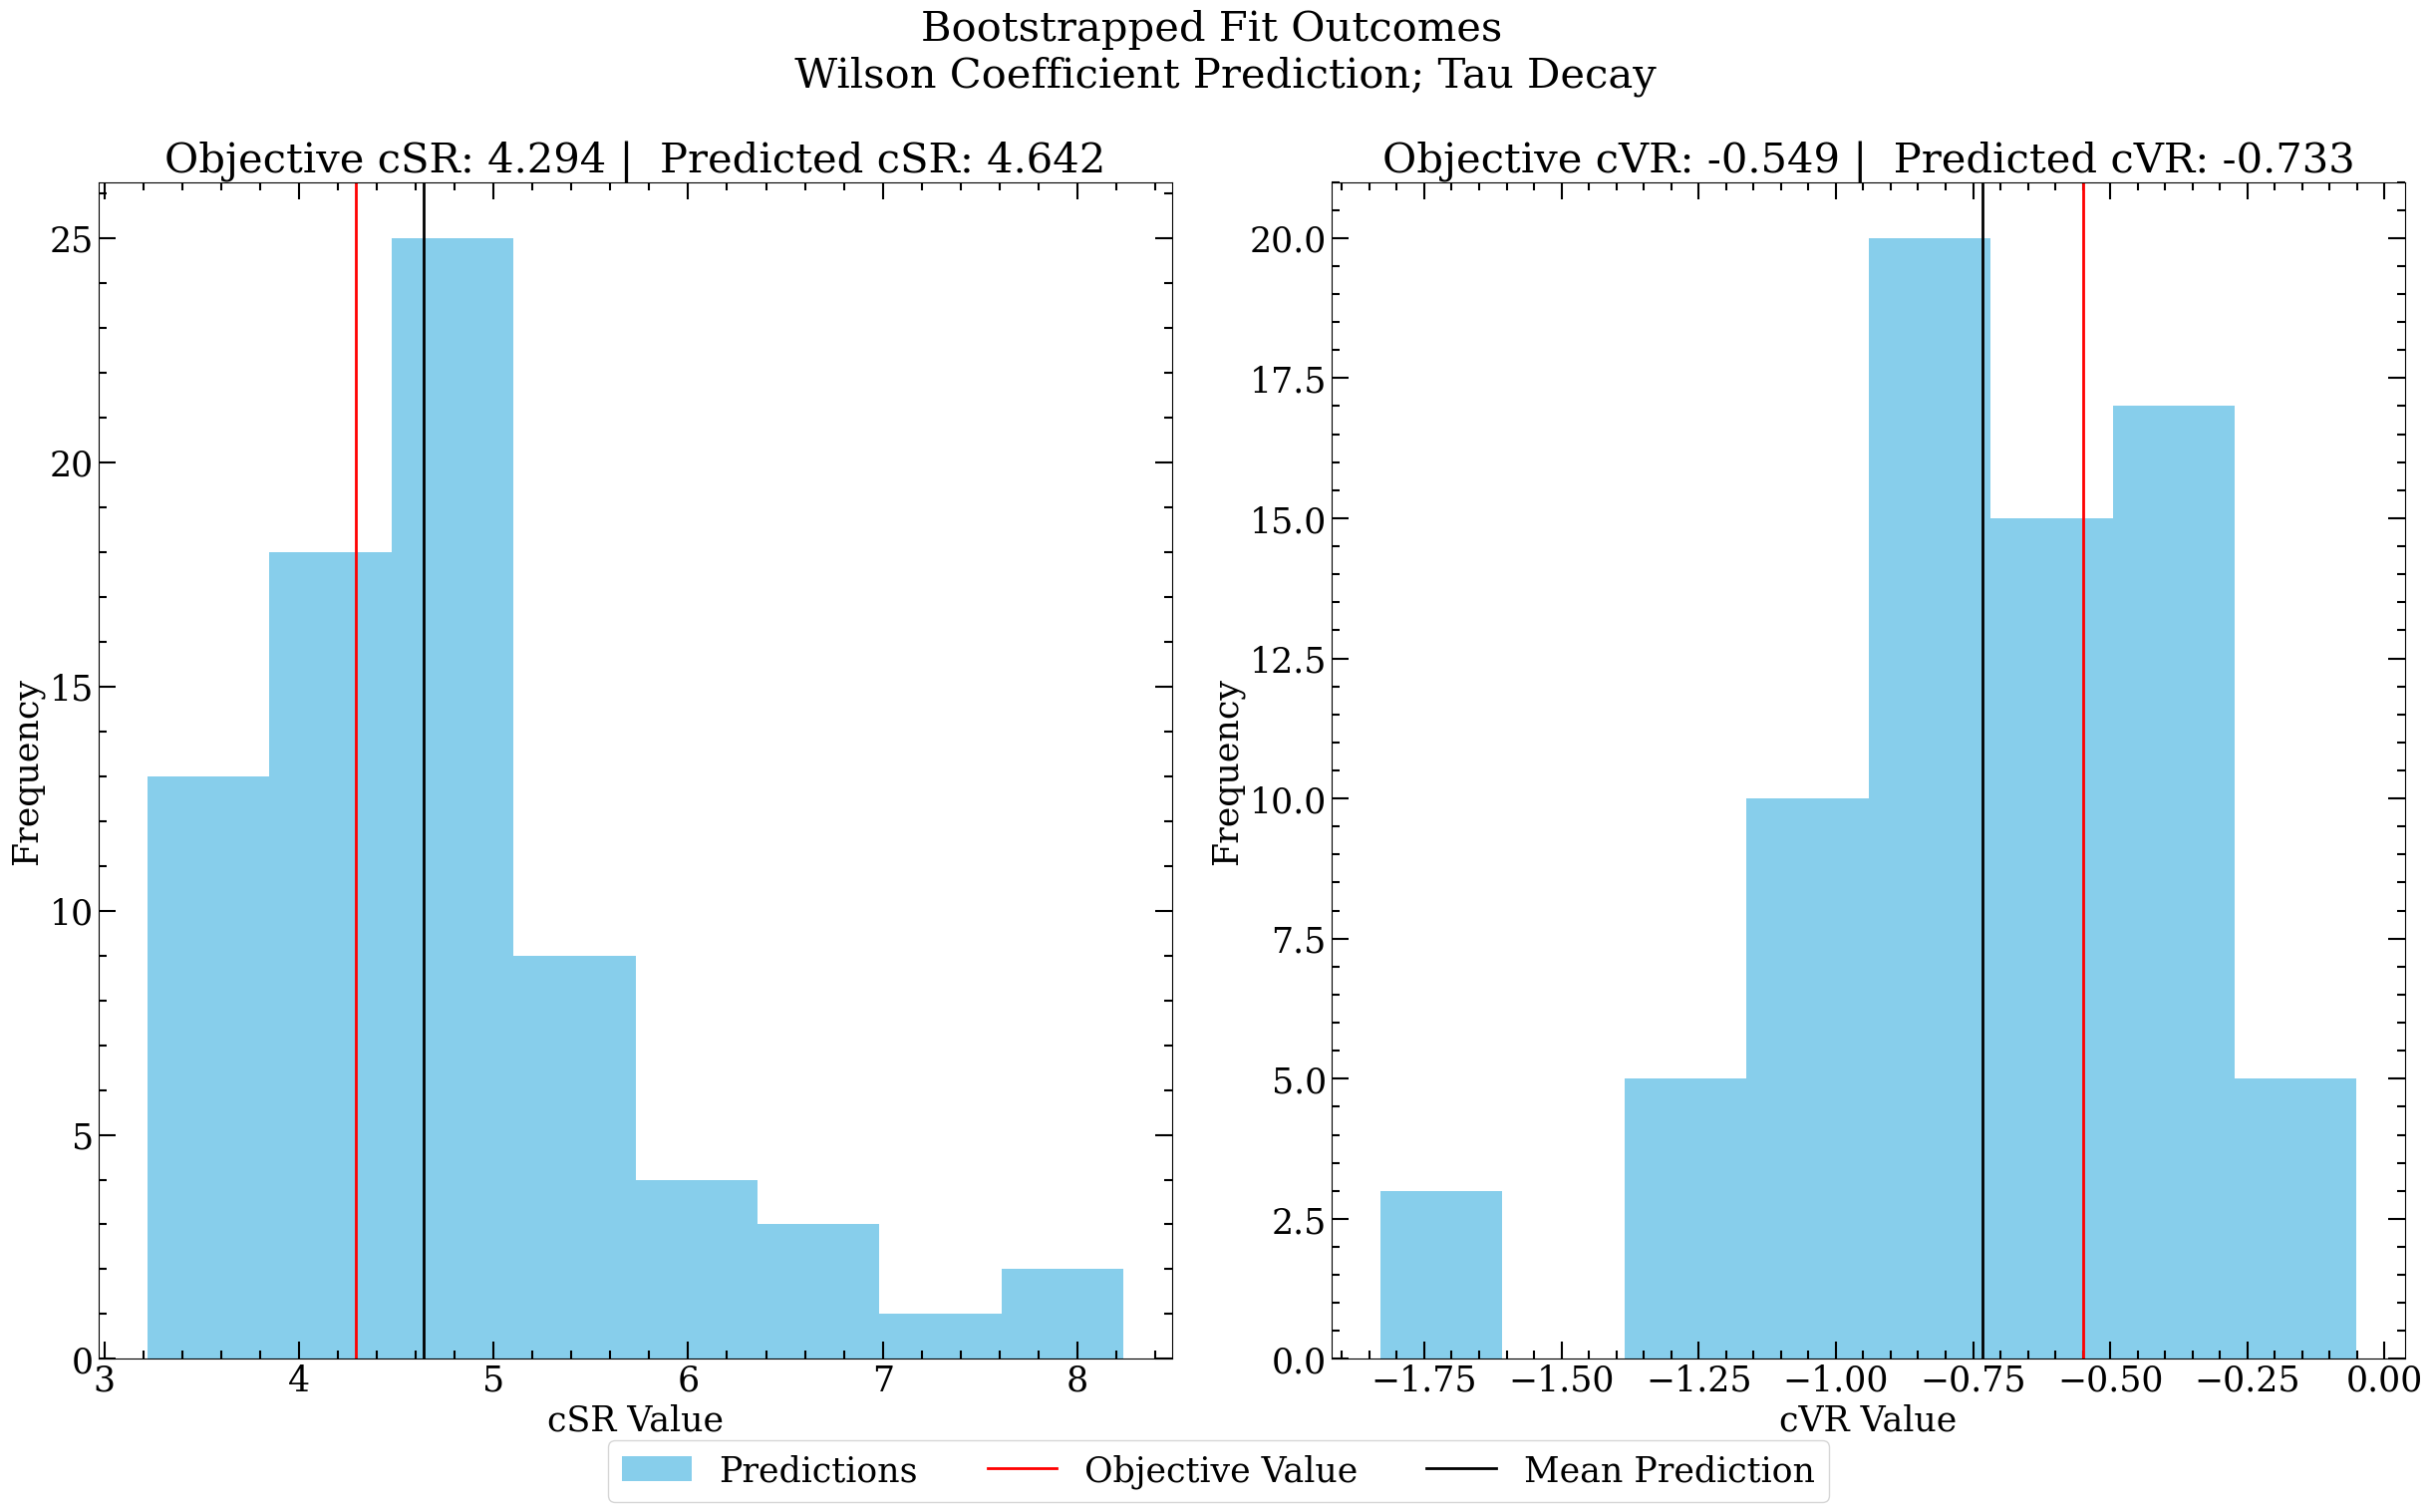

In [44]:
# Updated cell with subplots for cSR and cVR fit outcomes histograms

idx = [0, 1]  # Indices for cSR and cVR
col = ['cSR', 'cVR']

multi_resc = (np.array(multi) * 20) - 10# Ensure multi is a NumPy array

plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = 25

fig, axes = plt.subplots(1, 2, figsize=(25, 15))  # Create subplots with 1 row and 2 columns

for i, ax in enumerate(axes):  # Iterate over the indices and axes
    mean_pred = np.median(multi_resc[:, idx[i]])
    
    # Plot histogram for the current index
    ax.hist(multi_resc[:, idx[i]], bins=8, color='skyblue',  label=f'Predictions')
    
    # Add vertical lines for the actual value and mean prediction
    ax.axvline((actual_wc[f'wc_{idx[i]}'] * 20) - 10, color='red', linewidth=2, label='Objective Value')
    ax.axvline(mean_pred, color='black', label='Mean Prediction', linewidth=2)
    
    # Set labels, title, and limits

    ax.set_xlim()
    ax.set_xlabel(f'{col[idx[i]]} Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Objective {col[idx[i]]}: {(list(actual_wc.values())[idx[i]] * 20) - 10 :.3f} |  Predicted {col[idx[i]]}: {mean_pred:.3f}')
    
    # Add minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    # Configure tick parameters
    ax.tick_params(
        axis='both',
        which='major',
        direction='in',
        length=12,
        right=True,
        top=True,
        width=1.5,
    )
    ax.tick_params(
        axis='both',
        which='minor',
        direction='in',
        length=6,
        right=True,
        top=True,
        width=1.5,
    )

# Add a legend to the figure
fig.legend(
    handles=axes[0].get_legend_handles_labels()[0],  # Use handles from the first subplot
    labels=axes[0].get_legend_handles_labels()[1],  # Use labels from the first subplot
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.03),  # Adjust position
    fontsize=25
)

fig.suptitle('Bootstrapped Fit Outcomes \n Wilson Coefficient Prediction; Tau Decay')

plt.tight_layout()
plt.show()

## 8. Performance Evaluations

**Finds Memory used, run-time, number of parameters, etc.**

In [40]:
def count_parameters(state_dict):
    total_params = 0
    for param_tensor in state_dict:
        total_params += state_dict[param_tensor].numel()
    return total_params

# Load the state dictionary from the .pth file
state_dict = torch.load(normal_path + '/CVAE_tau_4d.pth', weights_only=False)

# Count the number of parameters
total_params = count_parameters(state_dict)

print(f'Total number of parameters: {total_params}')

Total number of parameters: 5712840


In [21]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil

fixed_inputs = torch.Tensor([0.25, 0.75]).to(DEVICE)

csr_model_gen = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], 
                            encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                            dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

csr_model_gen.load_state_dict(torch.load('nn_outputs/wilson_mu_csr_cvr/CVAE_mu_4d.pth', weights_only=False))
csr_model_gen.to(DEVICE)

model_heights_list = []
int_heights_list = []

time_list = []
memory_usage_list = []
mean_mem = []

nbins=10

eos_ref = pd.read_csv('nn_outputs/wilson_mu_csr_cvr/normal_targets/model_WET_mu_14.csv', index_col = 0)

process = psutil.Process()
# for j in range(10):
    # memory_usage_list = []
for i in range(250):
    with torch.no_grad():
        start_time = time.time()

        # Measure memory usage before model generation
        mem_before = process.memory_info().rss

        sample = csr_model_gen.generate_histogram(fixed_inputs)

        outputs = sample.to('cpu')

        result_df = pd.DataFrame({
                'q2':  eos_ref['q2'].values,
                'cos_theta_l': eos_ref['cos_theta_l'].values,
                'cos_theta_d': eos_ref['cos_theta_d'].values,
                'phi': eos_ref['phi'].values,
                'bin_height': outputs.ravel()
            })
        
        df_integrated = result_df.groupby(['cos_theta_l'])["bin_height"].sum().reset_index()

        # Measure memory usage after model generation
        mem_after = process.memory_info().rss

        end_time = time.time()
        sample = sample.cpu().numpy()

        # Calculate memory usage for the model generation
        mem_usage = mem_after - mem_before
        memory_usage_list.append(mem_usage)

        delta = end_time - start_time

        time_list.append(delta)
        model_heights_list.append(result_df)
        int_heights_list.append(result_df['bin_height'].values)


# Print memory usage statistics
# print(f"Average memory usage per iteration: {np.mean(memory_usage_list) / (1024 ** 2):.2f} MB")
# print(f"Maximum memory usage in an iteration: {np.max(memory_usage_list) / (1024 ** 2):.2f} MB")
# print(f"Minimum memory usage in an iteration: {np.min(memory_usage_list) / (1024 ** 2):.2f} MB")

## 9. Rough Work - Random Tests of Specific Functionality

## Generative Capacity Evaluation

In [ ]:
# Read in EOS Simulated Data and EOS rescaling factors
# eos_files = glob.glob('nn_outputs/wilson_tau_csr_cvr_fixed/normal_targets/*.csv')

# eos_rescale_path = 'nn_outputs/wilson_tau_csr_cvr_fixed/rescale_info.json'
# with open(eos_rescale_path, 'r') as f:
#     eos_factors = json.load(f)

idx = 4634

df = model_heights_list[0]
centers = df.loc[idx, :]

plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = 20

eos_heights = []

# for f in tqdm(eos_files):
#     df_eos = pd.read_csv(f)
#     eos_heights.append(df_eos['bin_height'].values)

# Array initiate for model and eos, and read in model rescaling properties
eos_heights = np.array(eos_heights)
model_heights = np.array(int_heights_list)

rescale_path = os.path.join(normal_path, 'rescale_info.json')

with open(rescale_path, 'r') as f:
    factors = json.load(f)

# Rescale the bin-heights appropriately
model_rescaled = (model_heights * (factors['max_height'] - factors['min_height'])) + factors['min_height']
# eos_rescaled = (eos_heights * (eos_factors['max_height'] - eos_factors['min_height'])) + eos_factors['min_height']

# plot out the histogram of bin heights to see variations

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter

plt.figure(figsize=(15, 10))


plt.hist(model_rescaled[:, idx], bins=20, color='white', hatch='//', edgecolor='blue', 
         label=f'Bin Center: $q^2$ = {centers.values[0]:.3f}; $\cos(\\theta_l)$ = {centers.values[1]:.3f}; \n \
                  $\cos(\\theta_d)$ = {centers.values[2]:.3f}; $\phi$ = {centers.values[3]:.3f} ')
plt.xlim((min(model_rescaled[:, idx]), max(model_rescaled[:, idx])))
# Uncomment the following line if you want to include the EOS histogram
# plt.hist(eos_rescaled[:, idx], bins=10, color='orange', alpha=0.5, edgecolor='black', label='EOS Bin-Height Variability')

ax = plt.gca()  # Get the current axis

# Set minor locators for both axes
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Set scientific notation for the y-axis
# formatter = ScalarFormatter(useMathText=True)
# formatter.set_powerlimits((0, 0))  # Forces scientific notation with x10^4
# ax.yaxis.set_major_formatter(formatter)

# Configure tick parameters
ax.tick_params(
    axis='both',
    which='major',
    direction='in',
    length=12,
    right=True,
    top=True,
    width=1.5,
)

ax.tick_params(
    axis='both',
    which='minor',
    direction='in',
    length=6,
    right=True,
    top=True,
    width=1.5,
)

handles, labels = ax.get_legend_handles_labels()

# Add labels, title, and legend
plt.xlabel('Bin height')
plt.ylabel('Frequency')
plt.title('Bin Height Variability of CVAE Outputs')

plt.legend(
        handles=handles,  # Ensure you pass the correct handles for the legend
        labels=labels,    # Ensure you pass the correct labels for the legend
        loc='lower center',
        ncol=2,
        bbox_to_anchor=(0.5, -0.25),  # Centered at the bottom
        fontsize=20
    )
# plt.tight_layout()
# Display the plot
plt.show()

In [23]:
variations = np.std(model_rescaled, axis=0)
print('Variations in CVAE Outputs:', np.mean(variations), '±', np.std(variations))

Variations in CVAE Outputs: 0.39836612 ± 0.21731195


## Latent Space Behaviour Evaluation

In [ ]:
CVAE = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], 
                   encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                   dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

CVAE.load_state_dict(torch.load('nn_outputs/wilson_tau_csr_cvr_KLD_0.1/CVAE_tau_4d.pth', weights_only=False))

num_points = 20  # You can adjust this value as needed
x = np.linspace(0, 1, num_points, endpoint=False)
y = np.linspace(0, 1, num_points, endpoint=False)
xx, yy = np.meshgrid(x, y)
meshgrid_array = np.vstack([xx.ravel(), yy.ravel()]).T

meshgrid_tensor = torch.tensor(meshgrid_array, dtype=torch.float32)

mean, logvar = CVAE.encoder(meshgrid_tensor)

print('Log-Variations:', logvar)
print('Means:', mean)

## WC Statistics Variation

In [4]:
list_eos = glob.glob('raw_data/dstore_mu_csr_cvr/*.csv')

json_eos = ['raw_data/dstore_mu_csr_cvr/' + os.path.basename(f).replace('.csv', '.json') for f in list_eos]

means = []
stds = []
wcs = []

for f, i in tqdm(zip(list_eos, json_eos)):
    # df = pd.read_csv(f)

    # mu = df.mean()
    # sigma = df.std()

    # means.append(mu.values)
    # stds.append(sigma.values)

    with open(i, 'r') as file:
        wc = json.load(file)

    wcs.append(list(wc.values()))

means = np.array(means)
stds = np.array(stds)
wcs = np.array(wcs)
    

3570it [00:00, 6517.61it/s]


In [ ]:

# Set global font properties
plt.rcParams["font.family"] = "Serif"
plt.rcParams["font.size"] = 15

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Titles and Y-axis labels for each subplot
titles = [
    'Standard Devivation $q^2$ variation',
    'Standard Devivation $\\cos(\\theta_l)$ variation',
    'Standard Devivation $\\cos(\\theta_d)$ variation ',
    'Standard Devivation $\\phi$ variation'
]

y_labels = [
    'Standard Devivation $q^2$',
    'Standard Devivation $\\cos(\\theta_l)$',
    'Standard Devivation $\\cos(\\theta_d)$',
    'Standard Devivation $\\phi$'
]

# Loop through each subplot and plot the data
for i, ax in enumerate(axes.flat):
    ax.plot(wcs, stds[:, i], 'o', color='black', label=f'Mean {i + 1}')
    ax.set_xlabel('Wilson Coefficient: cSR')
    ax.set_ylabel(y_labels[i])
    ax.grid()
    ax.set_title(titles[i])

# Adjust layout and show the plot

plt.suptitle('Standard Deviation of Observables Variation \n Muon Decay Mode, Wilson Coefficient cSR')
plt.tight_layout()
plt.show()

fig.savefig('std_var_csr.png')

## Model Loss Uncertainty 

In [ ]:
final_train_loss = []
final_val_loss = []

for i in tqdm(range(25)):

    loss_func = loss_function_KLD
    base = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'],
                        encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                    dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

    base.to(DEVICE)

    # =-=-=-= 1. Optimiser specified =-=-=-=
    optimiser = torch.optim.AdamW(base.parameters(), lr=1e-3, weight_decay=1e-4)

    # 2. Early Stopping Conditions - adjust only the patience value based on How constrained you want it.
    early_stopping_patience = 10
    best_val_loss = np.inf
    epochs_without_improvement = 0

    for epoch in range(cfg['epochs']):
        avg_loss, avg_val_loss = nt.train_epoch_early_CVAE(base, load_train, load_val, loss_func, optimiser, DEVICE)
        

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0

        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break
    
    final_train_loss.append(avg_loss)
    final_val_loss.append(avg_val_loss)



In [53]:
mu_loss = np.mean(final_train_loss)
mu_val = np.mean(final_val_loss)
print(mu_loss)
print(mu_val)

print(np.std(final_train_loss))
print(np.std(final_val_loss))

## Sampled Wilson Coefficient Variations

In [5]:
input_list = glob.glob('raw_data/dstore_tau_csr_cvr/*.json')

csr = []
cvr = []

for i in input_list:

    with open(i, 'r') as file:
        wc = json.load(file)

    csr.append(wc['cSR'])
    cvr.append(wc['cVR'])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 30
# Compute the 2D histogram
bins = 20  # Number of bins for the histogram
hist, x_edges, y_edges = np.histogram2d(csr, cvr, bins=bins)

# Plot the 2D heatmap
plt.figure(figsize=(19, 15), dpi=400)
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')

# Add labels and title
plt.xlabel(r'$\text{Re}\{C_{S_R}^{cbl\bar{\nu}_l}\}$')
plt.ylabel(r'$\text{Re}\{C_{V_R}^{cbl\bar{\nu}_l}\}$')
plt.title('2D Heatmap of Sampled Wilson Coefficients')

# Add a color bar
plt.colorbar(label='Frequency')
plt.savefig('sampled_wcs.png')
plt.tight_layout()
# Show the plot
plt.show()

## 10. $R^2$ Score of Model Reconstructed Histograms

In [32]:
from sklearn.metrics import  r2_score

files = glob.glob('nn_outputs/wilson_mu_csr_cvr/model_outputs/*.csv')
fnames = [os.path.basename(f) for f in files]

ps = []

for fname in tqdm(fnames):
    eos_path = os.path.join('nn_outputs/wilson_mu_csr_cvr/normal_targets', fname)
    nn_path = os.path.join('nn_outputs/wilson_mu_csr_cvr/model_outputs', fname)

    # Load the datasets
    df_eos = pd.read_csv(eos_path)
    df_nn = pd.read_csv(nn_path)

    # Drop 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df_eos.columns:
        df_eos = df_eos.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in df_nn.columns:
        df_nn = df_nn.drop(columns=['Unnamed: 0'])

    # Extract observable names dynamically (exclude "bin_height")
    observables = [col for col in df_eos.columns if col != "bin_height"]


    plt.rcParams["font.family"] = "Serif"
    plt.rcParams['font.size'] = 25

    # Loop through each observable and plot it
    for i, obs in enumerate(observables):
        # Integrate over the remaining columns for the current observable
        df_eos_integrated = df_eos.groupby([obs])["bin_height"].sum().reset_index()
        df_nn_integrated = df_nn.groupby([obs])["bin_height"].sum().reset_index()

        # Extract the heights for EOS and NN
        height_eos = df_eos_integrated["bin_height"].values
        height_nn = df_nn_integrated["bin_height"].values

        r2 = r2_score(height_eos, height_nn)
        ps.append(r2)

print("$R^2$ Score of Model Outputs:", np.mean(ps), '±', np.std(ps))
        

100%|██████████| 536/536 [00:08<00:00, 62.05it/s]

$R^2$ Score of Model Outputs: 0.924306352829786 ± 0.4368538179107873
